In [ ]:
# %pip install xgboost
# %pip install catboost
# %pip install imbalanced-learn    # for smote
# %pip install matplotlib
# %pip install scikit-learn
# %pip install imblearn
# %pip install lightgbm

In [1]:
# dataset preprocessing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split , StratifiedKFold
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek

# model training
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, StackingClassifier, VotingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, accuracy_score, balanced_accuracy_score, roc_auc_score
from sklearn.preprocessing import label_binarize

In [2]:
df = pd.read_parquet('cleaned_customer_support_data.parquet')

df[:20]

,channel_name,category,Sub-category,Agent_name,Supervisor,Manager,Tenure Bucket,Agent Shift,CSAT Score,Respond_time
0,Outcall,Product Queries,Life Insurance,Richard Buchanan,Mason Gupta,Jennifer Nguyen,On Job Training,Morning,5,0.57
1,Outcall,Product Queries,Product Specific Information,Vicki Collins,Dylan Kim,Michael Lee,>90,Morning,5,0.03
2,Inbound,Order Related,Installation/demo,Duane Norman,Jackson Park,William Kim,On Job Training,Evening,5,0.37
3,Inbound,Returns,Reverse Pickup Enquiry,Patrick Flores,Olivia Wang,John Smith,>90,Evening,5,0.33
4,Inbound,Cancellation,Not Needed,Christopher Sanchez,Austin Johnson,Michael Lee,0-30,Morning,5,0.03
5,Email,Returns,Fraudulent User,Desiree Newton,Emma Park,John Smith,0-30,Morning,5,3.43
6,Outcall,Product Queries,Product Specific Information,Shannon Hicks,Aiden Patel,Olivia Tan,>90,Morning,5,8.35
7,Inbound,Returns,Exchange / Replacement,Laura Smith,Evelyn Kimura,Jennifer Nguyen,On Job Training,Evening,5,0.10
8,Inbound,Returns,Missing,David Smith,Nathan Patel,John Smith,>90,Split,5,0.07
9,Inbound,Shopzilla Related,General Enquiry,Tabitha Ayala,Amelia Tanaka,Michael Lee,31-60,Evening,5,0.08


In [3]:
X = df.drop(columns=['CSAT Score'],axis=1)
y = df['CSAT Score']

In [4]:
feature_names = X.columns.tolist()
feature_names

['channel_name',
 'category',
 'Sub-category',
 'Agent_name',
 'Supervisor',
 'Manager',
 'Tenure Bucket',
 'Agent Shift',
 'Respond_time']

In [5]:
# Collecting features for transformation
X_num_features = [feature for feature in X.columns if X[feature].dtype != 'category']
X_cat_features = [feature for feature in X.columns if X[feature].dtype == 'category']

numeric_transformer = StandardScaler()
ordinal_encoder = OrdinalEncoder()  # Changed from OneHotEncoder

preprocessor = ColumnTransformer(
    transformers=[
        ('Encoding categories', ordinal_encoder, X_cat_features),
        ('Scaling the numerics', numeric_transformer, X_num_features)
    ]
)

In [6]:
X= preprocessor.fit_transform(X)

In [7]:
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=42,test_size=0.2, stratify=y)
print("X_train",X_train.shape)
print("y_train",y_train.shape)
print("X_test",X_test.shape)
print("y_test",y_test.shape)

X_train (68725, 9)
y_train (68725,)
X_test (17182, 9)
y_test (17182,)


In [8]:
lr = LogisticRegression(max_iter=2000, solver='lbfgs', multi_class='multinomial', class_weight='balanced')
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

print("Logistic Regression")
print(classification_report(y_test, y_pred, zero_division=0))
print("Accuracy:", accuracy_score(y_test, y_pred))
print("_" * 50)
print("Balanced Accuracy:", balanced_accuracy_score(y_test, y_pred))
print("_" * 50)

y_test_bin = label_binarize(y_test, classes=[1, 2, 3, 4, 5])
y_pred_bin = label_binarize(y_pred, classes=[1, 2, 3, 4, 5])
roc_auc = roc_auc_score(y_test_bin, y_pred_bin, multi_class='ovr', average='macro')
print("ROC-AUC Score (macro, OVR):", roc_auc)
print("_" * 50)

c:\Users\dheeraj\miniconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Logistic Regression
              precision    recall  f1-score   support

           1       0.22      0.28      0.25      2246
           2       0.02      0.15      0.03       256
           3       0.03      0.10      0.05       512
           4       0.14      0.09      0.11      2244
           5       0.74      0.55      0.63     11924

    accuracy                           0.43     17182
   macro avg       0.23      0.23      0.21     17182
weighted avg       0.56      0.43      0.48     17182

Accuracy: 0.43312769177045746
__________________________________________________
Balanced Accuracy: 0.23360767748467287
__________________________________________________
ROC-AUC Score (macro, OVR): 0.5257540377506622
__________________________________________________


c:\Users\dheeraj\miniconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 2000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=2000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [9]:
rf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf.fit(X_train, y_train )
y_pred = rf.predict(X_test)

print("Random Forest")
print(classification_report(y_test, y_pred, zero_division=0))
print("Accuracy:", accuracy_score(y_test, y_pred))
print("_" * 50)
print("Balanced Accuracy:", balanced_accuracy_score(y_test, y_pred))
print("_" * 50)

y_test_bin = label_binarize(y_test, classes=[1, 2, 3, 4, 5])
y_pred_bin = label_binarize(y_pred, classes=[1, 2, 3, 4, 5])
roc_auc = roc_auc_score(y_test_bin, y_pred_bin, multi_class='ovr', average='macro')
print("ROC-AUC Score (macro, OVR):", roc_auc)
print("_" * 50)

Random Forest
              precision    recall  f1-score   support

           1       0.25      0.12      0.16      2246
           2       0.02      0.01      0.01       256
           3       0.03      0.01      0.02       512
           4       0.14      0.06      0.08      2244
           5       0.70      0.88      0.78     11924

    accuracy                           0.63     17182
   macro avg       0.23      0.21      0.21     17182
weighted avg       0.54      0.63      0.57     17182

Accuracy: 0.6313001978815039
__________________________________________________
Balanced Accuracy: 0.21455566013313163
__________________________________________________
ROC-AUC Score (macro, OVR): 0.5103156651452702
__________________________________________________


In [10]:
cat = CatBoostClassifier(verbose=0)
cat.fit(X_train, y_train)
y_pred_cat = cat.predict(X_test)

print("CatBoost")
print(classification_report(y_test, y_pred, zero_division=0))
print("Accuracy:", accuracy_score(y_test, y_pred))
print("_" * 50)
print("Balanced Accuracy:", balanced_accuracy_score(y_test, y_pred))
print("_" * 50)

y_test_bin = label_binarize(y_test, classes=[1, 2, 3, 4, 5])
y_pred_bin = label_binarize(y_pred, classes=[1, 2, 3, 4, 5])
roc_auc = roc_auc_score(y_test_bin, y_pred_bin, multi_class='ovr', average='macro')
print("ROC-AUC Score (macro, OVR):", roc_auc)
print("_" * 50)

CatBoost
              precision    recall  f1-score   support

           1       0.25      0.12      0.16      2246
           2       0.02      0.01      0.01       256
           3       0.03      0.01      0.02       512
           4       0.14      0.06      0.08      2244
           5       0.70      0.88      0.78     11924

    accuracy                           0.63     17182
   macro avg       0.23      0.21      0.21     17182
weighted avg       0.54      0.63      0.57     17182

Accuracy: 0.6313001978815039
__________________________________________________
Balanced Accuracy: 0.21455566013313163
__________________________________________________
ROC-AUC Score (macro, OVR): 0.5103156651452702
__________________________________________________


Model Training and Testing (with SMOTE onwards)

In [11]:
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=42,test_size=0.2, stratify=y)
print("X_train",X_train.shape)
print("y_train",y_train.shape)
print("X_test",X_test.shape)
print("y_test",y_test.shape)

X_train (68725, 9)
y_train (68725,)
X_test (17182, 9)
y_test (17182,)


In [12]:
# Step 5: Apply SMOTE on training data only
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

# Step 6: Check class distribution
print("Before SMOTE:\n", y_train.value_counts())
print("After SMOTE:\n", pd.Series(y_train_bal).value_counts())

Before SMOTE:
 CSAT Score
5    47693
1     8984
4     8975
3     2046
2     1027
Name: count, dtype: int64
After SMOTE:
 CSAT Score
3    47693
5    47693
4    47693
1    47693
2    47693
Name: count, dtype: int64


In [13]:
lr = LogisticRegression(max_iter=2000, solver='lbfgs', multi_class='multinomial', class_weight='balanced')
lr.fit(X_train_bal, y_train_bal)
y_pred = lr.predict(X_test)

print("Logistic Regression")
print(classification_report(y_test, y_pred, zero_division=0))
print("Accuracy:", accuracy_score(y_test, y_pred))
print("_" * 50)
print("Balanced Accuracy:", balanced_accuracy_score(y_test, y_pred))
print("_" * 50)

y_test_bin = label_binarize(y_test, classes=[1, 2, 3, 4, 5])
y_pred_bin = label_binarize(y_pred, classes=[1, 2, 3, 4, 5])
roc_auc = roc_auc_score(y_test_bin, y_pred_bin, multi_class='ovr', average='macro')
print("ROC-AUC Score (macro, OVR):", roc_auc)
print("_" * 50)

c:\Users\dheeraj\miniconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Logistic Regression
              precision    recall  f1-score   support

           1       0.20      0.34      0.25      2246
           2       0.02      0.10      0.04       256
           3       0.03      0.07      0.04       512
           4       0.13      0.22      0.16      2244
           5       0.73      0.44      0.55     11924

    accuracy                           0.38     17182
   macro avg       0.22      0.23      0.21     17182
weighted avg       0.55      0.38      0.43     17182

Accuracy: 0.37836107554417414
__________________________________________________
Balanced Accuracy: 0.2321788434105038
__________________________________________________
ROC-AUC Score (macro, OVR): 0.5230709630675938
__________________________________________________


c:\Users\dheeraj\miniconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 2000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=2000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [14]:
rf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf.fit(X_train_bal, y_train_bal )
y_pred = rf.predict(X_test)

print("Random Forest")
print(classification_report(y_test, y_pred, zero_division=0))
print("Accuracy:", accuracy_score(y_test, y_pred))
print("_" * 50)
print("Balanced Accuracy:", balanced_accuracy_score(y_test, y_pred))
print("_" * 50)

y_test_bin = label_binarize(y_test, classes=[1, 2, 3, 4, 5])
y_pred_bin = label_binarize(y_pred, classes=[1, 2, 3, 4, 5])
roc_auc = roc_auc_score(y_test_bin, y_pred_bin, multi_class='ovr', average='macro')
print("ROC-AUC Score (macro, OVR):", roc_auc)
print("_" * 50)

Random Forest
              precision    recall  f1-score   support

           1       0.25      0.20      0.23      2246
           2       0.07      0.03      0.04       256
           3       0.04      0.02      0.03       512
           4       0.12      0.07      0.09      2244
           5       0.72      0.82      0.76     11924

    accuracy                           0.61     17182
   macro avg       0.24      0.23      0.23     17182
weighted avg       0.55      0.61      0.57     17182

Accuracy: 0.6056920032592248
__________________________________________________
Balanced Accuracy: 0.22928820130160835
__________________________________________________
ROC-AUC Score (macro, OVR): 0.5216928657635275
__________________________________________________


In [15]:
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb.fit(X_train_bal, y_train_bal-1)
y_pred = xgb.predict(X_test)+1

print("XGBoost")
print(classification_report(y_test, y_pred, zero_division=0))
print("Accuracy:", accuracy_score(y_test, y_pred))
print("_" * 50)
print("Balanced Accuracy:", balanced_accuracy_score(y_test, y_pred))
print("_" * 50)

y_test_bin = label_binarize(y_test, classes=[1, 2, 3, 4, 5])
y_pred_bin = label_binarize(y_pred, classes=[1, 2, 3, 4, 5])
roc_auc = roc_auc_score(y_test_bin, y_pred_bin, multi_class='ovr', average='macro')
print("ROC-AUC Score (macro, OVR):", roc_auc)
print("_" * 50)

c:\Users\dheeraj\miniconda3\Lib\site-packages\xgboost\training.py:199: UserWarning: [09:32:37] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost
              precision    recall  f1-score   support

           1       0.30      0.25      0.27      2246
           2       0.07      0.02      0.04       256
           3       0.04      0.00      0.01       512
           4       0.11      0.01      0.02      2244
           5       0.72      0.91      0.80     11924

    accuracy                           0.66     17182
   macro avg       0.25      0.24      0.23     17182
weighted avg       0.56      0.66      0.60     17182

Accuracy: 0.663019438947736
__________________________________________________
Balanced Accuracy: 0.23789866029393156
__________________________________________________
ROC-AUC Score (macro, OVR): 0.5285140508784058
__________________________________________________


In [16]:
cat = CatBoostClassifier(verbose=0)
cat.fit(X_train_bal, y_train_bal)
y_pred_cat = cat.predict(X_test)

print("CatBoost")
print(classification_report(y_test, y_pred, zero_division=0))
print("Accuracy:", accuracy_score(y_test, y_pred))
print("_" * 50)
print("Balanced Accuracy:", balanced_accuracy_score(y_test, y_pred))
print("_" * 50)

y_test_bin = label_binarize(y_test, classes=[1, 2, 3, 4, 5])
y_pred_bin = label_binarize(y_pred, classes=[1, 2, 3, 4, 5])
roc_auc = roc_auc_score(y_test_bin, y_pred_bin, multi_class='ovr', average='macro')
print("ROC-AUC Score (macro, OVR):", roc_auc)
print("_" * 50)

CatBoost
              precision    recall  f1-score   support

           1       0.30      0.25      0.27      2246
           2       0.07      0.02      0.04       256
           3       0.04      0.00      0.01       512
           4       0.11      0.01      0.02      2244
           5       0.72      0.91      0.80     11924

    accuracy                           0.66     17182
   macro avg       0.25      0.24      0.23     17182
weighted avg       0.56      0.66      0.60     17182

Accuracy: 0.663019438947736
__________________________________________________
Balanced Accuracy: 0.23789866029393156
__________________________________________________
ROC-AUC Score (macro, OVR): 0.5285140508784058
__________________________________________________


# Changing the labels from 1-5 to 1-3
For our use case, we actually dont care if CSAT score is 4/5 or 1/2. Instead, we want to understand the major features, and make a real time predictive model, which can help us pick the customers we must focus on in present.

In [17]:
X.shape, y.shape

((85907, 9), (85907,))

In [18]:
y.value_counts(normalize=True)*100

CSAT Score
5    69.397139
1    13.072276
4    13.059471
3     2.977639
2     1.493476
Name: proportion, dtype: float64

In [19]:
label_mapping = {
    1:1 ,  #negative
    2:1,   #negative
    3:2,   #neutral
    4:2,   #neutral
    5:3    #positive
}

y = y.map(label_mapping)

y.value_counts(normalize=True)*100

CSAT Score
3    69.397139
2    16.037110
1    14.565751
Name: proportion, dtype: float64

In [20]:
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=42,test_size=0.2, stratify=y)
print("X_train",X_train.shape)
print("y_train",y_train.shape)
print("X_test",X_test.shape)
print("y_test",y_test.shape)

X_train (68725, 9)
y_train (68725,)
X_test (17182, 9)
y_test (17182,)


Applying SMOTE

In [21]:
#  Apply SMOTE on training data only
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

# Step 6: Check class distribution
print("Before SMOTE:\n", y_train.value_counts(normalize=True)*100)
print("After SMOTE:\n", pd.Series(y_train_bal).value_counts(normalize=True)*100)

Before SMOTE:
 CSAT Score
3    69.396872
2    16.037832
1    14.565296
Name: proportion, dtype: float64
After SMOTE:
 CSAT Score
3    33.333333
1    33.333333
2    33.333333
Name: proportion, dtype: float64


Lets train the model now

In [22]:
lr = LogisticRegression(max_iter=2000, solver='lbfgs', multi_class='multinomial', class_weight='balanced')
lr.fit(X_train_bal, y_train_bal)
y_pred = lr.predict(X_test)

print("Logistic Regression")
print(classification_report(y_test, y_pred, zero_division=0))
print("Accuracy:", accuracy_score(y_test, y_pred))
print("_" * 50)
print("Balanced Accuracy:", balanced_accuracy_score(y_test, y_pred))
print("_" * 50)

y_test_bin = label_binarize(y_test, classes=[1, 2, 3])
y_pred_bin = label_binarize(y_pred, classes=[1, 2, 3])
roc_auc = roc_auc_score(y_test_bin, y_pred_bin, multi_class='ovr', average='macro')
print("ROC-AUC Score (macro, OVR):", roc_auc)
print("_" * 50)

c:\Users\dheeraj\miniconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Logistic Regression
              precision    recall  f1-score   support

           1       0.21      0.46      0.29      2503
           2       0.16      0.18      0.17      2755
           3       0.74      0.53      0.61     11924

    accuracy                           0.46     17182
   macro avg       0.37      0.39      0.36     17182
weighted avg       0.57      0.46      0.50     17182

Accuracy: 0.4631591200093121
__________________________________________________
Balanced Accuracy: 0.3913525008432261
__________________________________________________
ROC-AUC Score (macro, OVR): 0.5443828006781476
__________________________________________________


c:\Users\dheeraj\miniconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 2000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=2000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [23]:
rf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf.fit(X_train_bal, y_train_bal )
y_pred = rf.predict(X_test)

print("Random Forest")
print(classification_report(y_test, y_pred, zero_division=0))
print("Accuracy:", accuracy_score(y_test, y_pred))
print("_" * 50)
print("Balanced Accuracy:", balanced_accuracy_score(y_test, y_pred))
print("_" * 50)

y_test_bin = label_binarize(y_test, classes=[1, 2, 3])
y_pred_bin = label_binarize(y_pred, classes=[1, 2, 3])
roc_auc = roc_auc_score(y_test_bin, y_pred_bin, multi_class='ovr', average='macro')
print("ROC-AUC Score (macro, OVR):", roc_auc)
print("_" * 50)

Random Forest
              precision    recall  f1-score   support

           1       0.28      0.23      0.25      2503
           2       0.18      0.11      0.13      2755
           3       0.72      0.81      0.76     11924

    accuracy                           0.61     17182
   macro avg       0.39      0.38      0.38     17182
weighted avg       0.57      0.61      0.59     17182

Accuracy: 0.6144802700500523
__________________________________________________
Balanced Accuracy: 0.38322338301651415
__________________________________________________
ROC-AUC Score (macro, OVR): 0.5395562425792111
__________________________________________________


In [24]:
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb.fit(X_train_bal, y_train_bal-1)
y_pred = xgb.predict(X_test)+1

print("XGBoost")
print(classification_report(y_test, y_pred, zero_division=0))
print("Accuracy:", accuracy_score(y_test, y_pred))
print("_" * 50)
print("Balanced Accuracy:", balanced_accuracy_score(y_test, y_pred))
print("_" * 50)

y_test_bin = label_binarize(y_test, classes=[1, 2, 3])
y_pred_bin = label_binarize(y_pred, classes=[1, 2, 3])
roc_auc = roc_auc_score(y_test_bin, y_pred_bin, multi_class='ovr', average='macro')
print("ROC-AUC Score (macro, OVR):", roc_auc)
print("_" * 50)

c:\Users\dheeraj\miniconda3\Lib\site-packages\xgboost\training.py:199: UserWarning: [09:36:41] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost
              precision    recall  f1-score   support

           1       0.32      0.29      0.30      2503
           2       0.22      0.03      0.05      2755
           3       0.73      0.89      0.80     11924

    accuracy                           0.66     17182
   macro avg       0.42      0.40      0.39     17182
weighted avg       0.59      0.66      0.61     17182

Accuracy: 0.6638924455825864
__________________________________________________
Balanced Accuracy: 0.40204459355108185
__________________________________________________
ROC-AUC Score (macro, OVR): 0.5549148788336109
__________________________________________________


In [25]:
cat = CatBoostClassifier(verbose=0)
cat.fit(X_train_bal, y_train_bal)
y_pred_cat = cat.predict(X_test)

print("CatBoost")
print(classification_report(y_test, y_pred, zero_division=0))
print("Accuracy:", accuracy_score(y_test, y_pred))
print("_" * 50)
print("Balanced Accuracy:", balanced_accuracy_score(y_test, y_pred))
print("_" * 50)

y_test_bin = label_binarize(y_test, classes=[1, 2, 3])
y_pred_bin = label_binarize(y_pred, classes=[1, 2, 3])
roc_auc = roc_auc_score(y_test_bin, y_pred_bin, multi_class='ovr', average='macro')
print("ROC-AUC Score (macro, OVR):", roc_auc)
print("_" * 50)

CatBoost
              precision    recall  f1-score   support

           1       0.32      0.29      0.30      2503
           2       0.22      0.03      0.05      2755
           3       0.73      0.89      0.80     11924

    accuracy                           0.66     17182
   macro avg       0.42      0.40      0.39     17182
weighted avg       0.59      0.66      0.61     17182

Accuracy: 0.6638924455825864
__________________________________________________
Balanced Accuracy: 0.40204459355108185
__________________________________________________
ROC-AUC Score (macro, OVR): 0.5549148788336109
__________________________________________________


Ensembling models

In [26]:
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

from sklearn.metrics import classification_report, accuracy_score, balanced_accuracy_score, roc_auc_score
from sklearn.preprocessing import label_binarize

# -------------------- Shifted Labels for XGBoost --------------------
# XGBoost requires 0-based class labels
y_train_shifted = y_train_bal - 1
y_test_shifted = y_test - 1

# -------------------- Define Models --------------------
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
cat = CatBoostClassifier(verbose=0, random_state=42)

# -------------------- Fit Individually --------------------
xgb.fit(X_train_bal, y_train_shifted)
cat.fit(X_train_bal, y_train_bal)

# -------------------- Predict Individually --------------------
y_pred_xgb = xgb.predict(X_test) + 1   # Add 1 to shift back to original label
y_pred_cat = cat.predict(X_test)

# -------------------- Voting Ensemble --------------------
voting_clf = VotingClassifier(estimators=[
    ('xgb', xgb),
    ('cat', cat)
], voting='soft')  # Use 'soft' if models support predict_proba()

voting_clf.fit(X_train_bal, y_train_shifted)  # XGBoost needs shifted labels

# -------------------- Predict with Ensemble --------------------
y_pred_ens = voting_clf.predict(X_test) + 1  # Convert back to original label (1, 2, 3)

# -------------------- Evaluation --------------------
print("📌 Ensemble (XGBoost + CatBoost)")
print(classification_report(y_test, y_pred_ens, zero_division=0))
print("Accuracy:", accuracy_score(y_test, y_pred_ens))
print("_" * 50)
print("Balanced Accuracy:", balanced_accuracy_score(y_test, y_pred_ens))
print("_" * 50)

# --- ROC-AUC ---
y_test_bin = label_binarize(y_test, classes=[1, 2, 3])
y_pred_bin = label_binarize(y_pred_ens, classes=[1, 2, 3])
roc_auc = roc_auc_score(y_test_bin, y_pred_bin, multi_class='ovr', average='macro')
print("ROC-AUC Score (macro, OVR):", roc_auc)
print("_" * 50)

c:\Users\dheeraj\miniconda3\Lib\site-packages\xgboost\training.py:199: UserWarning: [09:37:36] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\dheeraj\miniconda3\Lib\site-packages\xgboost\training.py:199: UserWarning: [09:38:32] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


📌 Ensemble (XGBoost + CatBoost)
              precision    recall  f1-score   support

           1       0.32      0.28      0.30      2503
           2       0.22      0.02      0.04      2755
           3       0.73      0.89      0.80     11924

    accuracy                           0.67     17182
   macro avg       0.42      0.40      0.38     17182
weighted avg       0.59      0.67      0.61     17182

Accuracy: 0.6652892561983471
__________________________________________________
Balanced Accuracy: 0.4008990748931213
__________________________________________________
ROC-AUC Score (macro, OVR): 0.553913498025025
__________________________________________________


In [27]:
from lightgbm import LGBMClassifier

# -------------------- Define Models --------------------
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
cat = CatBoostClassifier(verbose=0, random_state=42)
lgb = LGBMClassifier(random_state=42)

# -------------------- Shift Labels for XGBoost --------------------
y_train_shifted = y_train_bal - 1
y_test_shifted = y_test - 1

# -------------------- Fit Individually (Optional but Good for Debugging) --------------------
xgb.fit(X_train_bal, y_train_shifted)
cat.fit(X_train_bal, y_train_bal)
lgb.fit(X_train_bal, y_train_bal)

# -------------------- Voting Ensemble --------------------
voting_clf = VotingClassifier(
    estimators=[
        ('xgb', xgb),
        ('cat', cat),
        ('lgb', lgb)
    ],
    voting='soft'  # All support predict_proba
)

voting_clf.fit(X_train_bal, y_train_shifted)  # Only XGBoost cares about shifted labels

# -------------------- Predict --------------------
y_pred_ens = voting_clf.predict(X_test) + 1  # Shift back to original label (1, 2, 3)

# -------------------- Evaluation --------------------
from sklearn.metrics import classification_report, accuracy_score, balanced_accuracy_score, roc_auc_score
from sklearn.preprocessing import label_binarize

print("📌 Ensemble (XGBoost + CatBoost + LightGBM)")
print(classification_report(y_test, y_pred_ens, zero_division=0))
print("Accuracy:", accuracy_score(y_test, y_pred_ens))
print("_" * 50)
print("Balanced Accuracy:", balanced_accuracy_score(y_test, y_pred_ens))

# --- ROC-AUC ---
y_test_bin = label_binarize(y_test, classes=[1, 2, 3])
y_pred_bin = label_binarize(y_pred_ens, classes=[1, 2, 3])
roc_auc = roc_auc_score(y_test_bin, y_pred_bin, multi_class='ovr', average='macro')
print("_" * 50)
print("ROC-AUC Score (macro, OVR):", roc_auc)

c:\Users\dheeraj\miniconda3\Lib\site-packages\xgboost\training.py:199: UserWarning: [09:39:39] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002635 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2295
[LightGBM] [Info] Number of data points in the train set: 143079, number of used features: 9
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612


c:\Users\dheeraj\miniconda3\Lib\site-packages\xgboost\training.py:199: UserWarning: [09:40:38] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005688 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2295
[LightGBM] [Info] Number of data points in the train set: 143079, number of used features: 9
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
📌 Ensemble (XGBoost + CatBoost + LightGBM)
              precision    recall  f1-score   support

           1       0.32      0.29      0.30      2503
           2       0.21      0.02      0.03      2755
           3       0.73      0.89      0.80     11924

    accuracy                           0.67     17182
   macro avg       0.42      0.40      0.38     17182
weighted avg       0.58      0.67      0.61     17182

Accuracy: 0.665754859736934
__________________________________________________
Balanced Accuracy: 0.40043155437367234
_______

c:\Users\dheeraj\miniconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


# Pushing ROC AUC from 0.55 to 0.8
Trying a better SMOTE variant

In [28]:
label_mapping = {
    1:1 ,  #negative
    2:1,   #negative
    3:2,   #neutral
    4:2,   #neutral
    5:3    #positive
}

y = y.map(label_mapping)

y.value_counts(normalize=True)*100

CSAT Score
2    69.397139
1    30.602861
Name: proportion, dtype: float64

In [29]:
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=42,test_size=0.2, stratify=y)

#  Apply SMOTE on training data only
smk = SMOTETomek(random_state=42)
X_train_bal, y_train_bal  = smk.fit_resample(X_train, y_train)

# Step 6: Check class distribution
print("Before SMOTE:\n", y_train.value_counts(normalize=True)*100)
print("After SMOTE:\n", pd.Series(y_train_bal).value_counts(normalize=True)*100)

Before SMOTE:
 CSAT Score
2    69.396872
1    30.603128
Name: proportion, dtype: float64
After SMOTE:
 CSAT Score
2    50.0
1    50.0
Name: proportion, dtype: float64


Logistic Regression

In [30]:
lr = LogisticRegression(max_iter=2000, solver='lbfgs', multi_class='multinomial', class_weight='balanced')
lr.fit(X_train_bal, y_train_bal)
y_pred = lr.predict(X_test)

print("Logistic Regression")
print(classification_report(y_test, y_pred, zero_division=0))
print("Accuracy:", accuracy_score(y_test, y_pred))
print("_" * 50)
print("Balanced Accuracy:", balanced_accuracy_score(y_test, y_pred))
print("_" * 50)

y_test_bin = label_binarize(y_test, classes=[1, 2, 3])
y_pred_bin = label_binarize(y_pred, classes=[1, 2, 3])
roc_auc = roc_auc_score(y_test_bin, y_pred_bin, multi_class='ovr', average='macro')
print("ROC-AUC Score (macro, OVR):", roc_auc)
print("_" * 50)

c:\Users\dheeraj\miniconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1262: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(


Logistic Regression
              precision    recall  f1-score   support

           1       0.36      0.49      0.42      5258
           2       0.73      0.62      0.67     11924

    accuracy                           0.58     17182
   macro avg       0.55      0.56      0.54     17182
weighted avg       0.62      0.58      0.59     17182

Accuracy: 0.5795600046560354
__________________________________________________
Balanced Accuracy: 0.5550886086076532
__________________________________________________
ROC-AUC Score (macro, OVR): nan
__________________________________________________


c:\Users\dheeraj\miniconda3\Lib\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Random Forest

In [31]:
rf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf.fit(X_train_bal, y_train_bal )
y_pred = rf.predict(X_test)

print("Random Forest")
print(classification_report(y_test, y_pred, zero_division=0))
print("Accuracy:", accuracy_score(y_test, y_pred))
print("_" * 50)
print("Balanced Accuracy:", balanced_accuracy_score(y_test, y_pred))
print("_" * 50)

y_test_bin = label_binarize(y_test, classes=[1, 2, 3])
y_pred_bin = label_binarize(y_pred, classes=[1, 2, 3])
roc_auc = roc_auc_score(y_test_bin, y_pred_bin, multi_class='ovr', average='macro')
print("ROC-AUC Score (macro, OVR):", roc_auc)
print("_" * 50)

Random Forest
              precision    recall  f1-score   support

           1       0.41      0.29      0.34      5258
           2       0.72      0.81      0.77     11924

    accuracy                           0.65     17182
   macro avg       0.57      0.55      0.55     17182
weighted avg       0.63      0.65      0.64     17182

Accuracy: 0.6549295774647887
__________________________________________________
Balanced Accuracy: 0.553518693707287
__________________________________________________
ROC-AUC Score (macro, OVR): nan
__________________________________________________


c:\Users\dheeraj\miniconda3\Lib\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


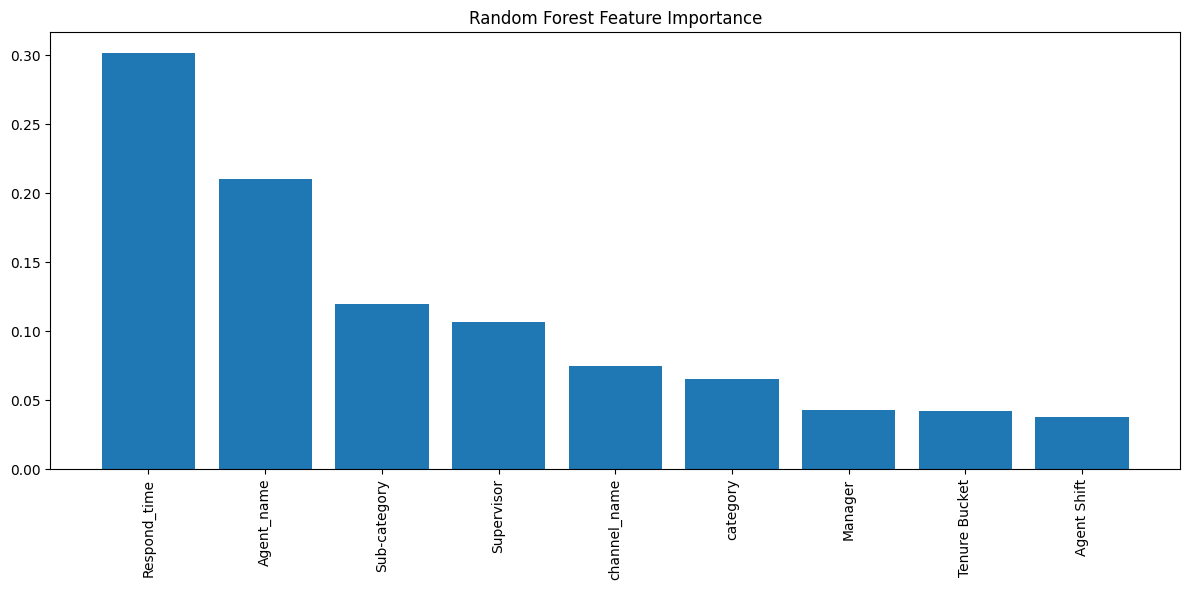

In [32]:
# Assuming rf is your trained RandomForestClassifier
rf_importances = rf.feature_importances_
indices_rf = np.argsort(rf_importances)[::-1]

plt.figure(figsize=(12, 6))
plt.title("Random Forest Feature Importance")
plt.bar(range(len(rf_importances)), rf_importances[indices_rf])
plt.xticks(range(len(rf_importances)), np.array(feature_names)[indices_rf], rotation=90)
plt.tight_layout()
plt.show()

XGBOOST

In [33]:
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb.fit(X_train_bal, y_train_bal-1)
y_pred = xgb.predict(X_test)+1

print("XGBoost")
print(classification_report(y_test, y_pred, zero_division=0))
print("Accuracy:", accuracy_score(y_test, y_pred))
print("_" * 50)
print("Balanced Accuracy:", balanced_accuracy_score(y_test, y_pred))
print("_" * 50)

y_test_bin = label_binarize(y_test, classes=[1, 2, 3])
y_pred_bin = label_binarize(y_pred, classes=[1, 2, 3])
roc_auc = roc_auc_score(y_test_bin, y_pred_bin, multi_class='ovr', average='macro')
print("ROC-AUC Score (macro, OVR):", roc_auc)
print("_" * 50)

c:\Users\dheeraj\miniconda3\Lib\site-packages\xgboost\training.py:199: UserWarning: [09:42:03] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost
              precision    recall  f1-score   support

           1       0.48      0.30      0.37      5258
           2       0.73      0.85      0.79     11924

    accuracy                           0.68     17182
   macro avg       0.61      0.58      0.58     17182
weighted avg       0.66      0.68      0.66     17182

Accuracy: 0.6849610057036434
__________________________________________________
Balanced Accuracy: 0.5771758445047364
__________________________________________________
ROC-AUC Score (macro, OVR): nan
__________________________________________________


c:\Users\dheeraj\miniconda3\Lib\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


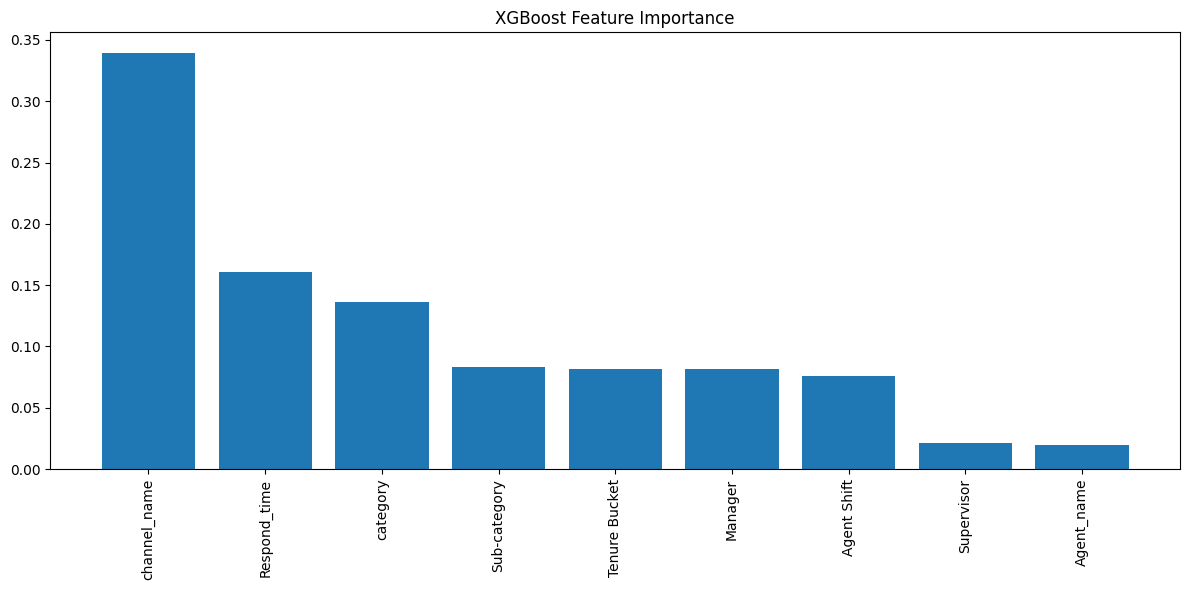

In [34]:
xgb_importances = xgb.feature_importances_
indices_xgb = np.argsort(xgb_importances)[::-1]

plt.figure(figsize=(12, 6))
plt.title("XGBoost Feature Importance")
plt.bar(range(len(xgb_importances)), xgb_importances[indices_xgb])
plt.xticks(range(len(xgb_importances)), np.array(feature_names)[indices_xgb], rotation=90)
plt.tight_layout()
plt.show()

Boooster Based- more accurate

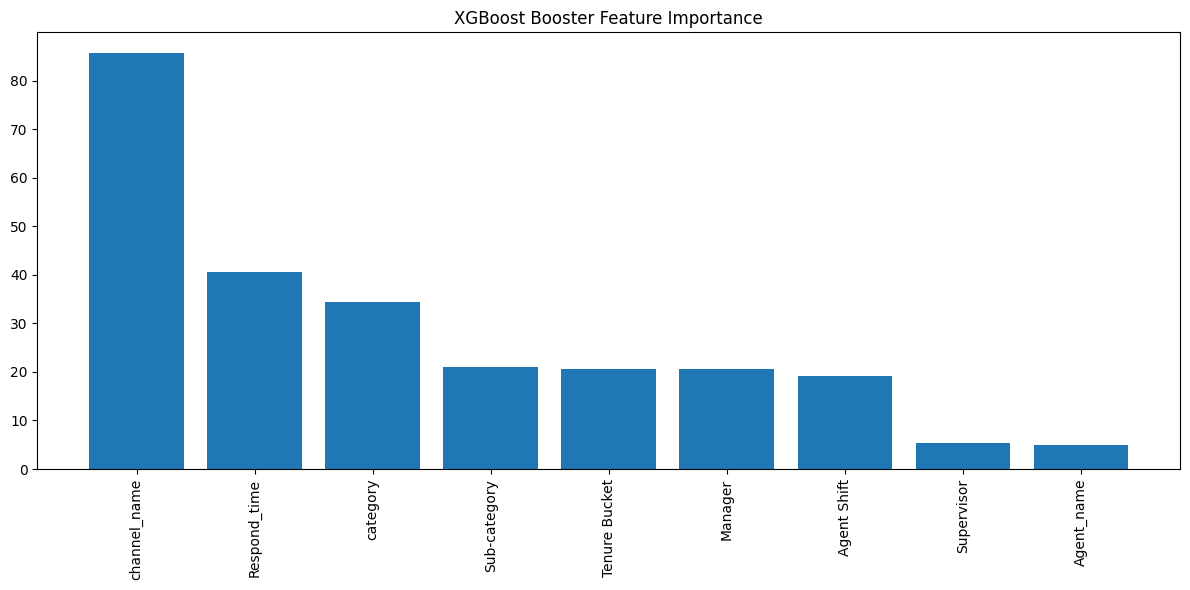

In [35]:
booster = xgb.get_booster()
importance_dict = booster.get_score(importance_type='gain')  # or 'weight', 'cover'
# Create array of importances aligned with feature_names
xgb_importances = [importance_dict.get(f'f{i}', 0) for i in range(len(feature_names))]
indices_xgb = np.argsort(xgb_importances)[::-1]

plt.figure(figsize=(12, 6))
plt.title("XGBoost Booster Feature Importance")
plt.bar(range(len(xgb_importances)), np.array(xgb_importances)[indices_xgb])
plt.xticks(range(len(xgb_importances)), np.array(feature_names)[indices_xgb], rotation=90)
plt.tight_layout()
plt.show()

Catboost

In [36]:
cat = CatBoostClassifier(verbose=0)
cat.fit(X_train_bal, y_train_bal)
y_pred_cat = cat.predict(X_test)

print("CatBoost")
print(classification_report(y_test, y_pred, zero_division=0))
print("Accuracy:", accuracy_score(y_test, y_pred))
print("_" * 50)
print("Balanced Accuracy:", balanced_accuracy_score(y_test, y_pred))
print("_" * 50)

y_test_bin = label_binarize(y_test, classes=[1, 2, 3])
y_pred_bin = label_binarize(y_pred, classes=[1, 2, 3])
roc_auc = roc_auc_score(y_test_bin, y_pred_bin, multi_class='ovr', average='macro')
print("ROC-AUC Score (macro, OVR):", roc_auc)

CatBoost
              precision    recall  f1-score   support

           1       0.48      0.30      0.37      5258
           2       0.73      0.85      0.79     11924

    accuracy                           0.68     17182
   macro avg       0.61      0.58      0.58     17182
weighted avg       0.66      0.68      0.66     17182

Accuracy: 0.6849610057036434
__________________________________________________
Balanced Accuracy: 0.5771758445047364
__________________________________________________
ROC-AUC Score (macro, OVR): nan


c:\Users\dheeraj\miniconda3\Lib\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


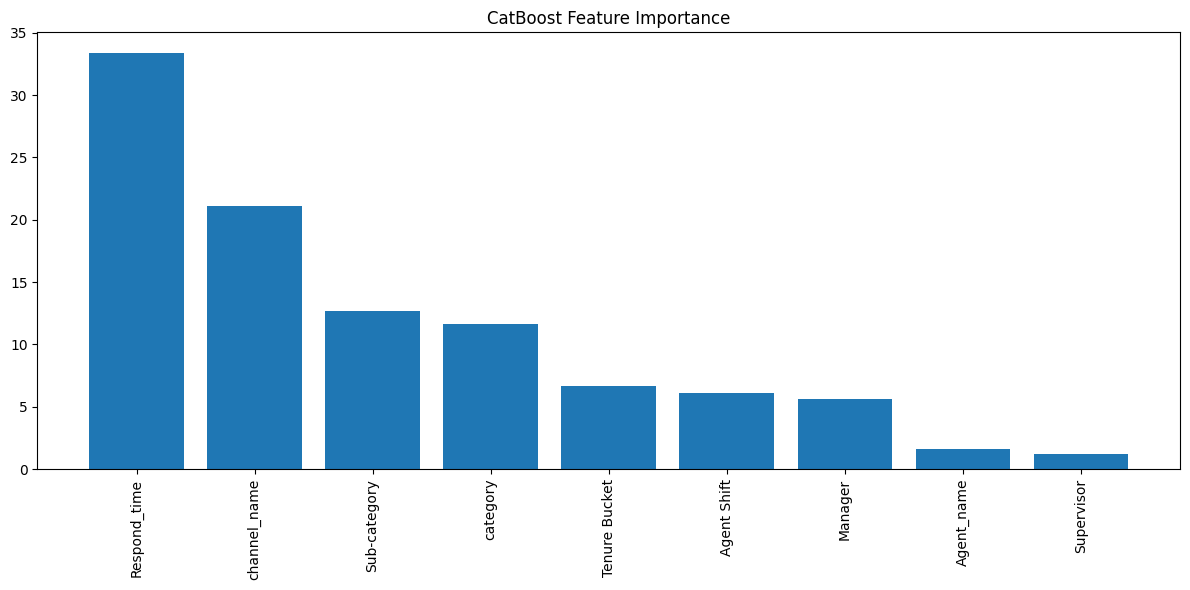

In [37]:
cat_importances = cat.get_feature_importance()
indices_cat = np.argsort(cat_importances)[::-1]

plt.figure(figsize=(12, 6))
plt.title("CatBoost Feature Importance")
plt.bar(range(len(cat_importances)), np.array(cat_importances)[indices_cat])
plt.xticks(range(len(cat_importances)), np.array(feature_names)[indices_cat], rotation=90)
plt.tight_layout()
plt.show()

Ensemble (XGBoost + CatBoost + LightGBM) - Voting Classifier

In [38]:
from lightgbm import LGBMClassifier

# -------------------- Define Models --------------------
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
cat = CatBoostClassifier(verbose=0, random_state=42)
lgb = LGBMClassifier(random_state=42)

# -------------------- Shift Labels for XGBoost --------------------
y_train_shifted = y_train_bal - 1
y_test_shifted = y_test - 1

# -------------------- Fit Individually (Optional but Good for Debugging) --------------------
xgb.fit(X_train_bal, y_train_shifted)
cat.fit(X_train_bal, y_train_bal)
lgb.fit(X_train_bal, y_train_bal)

# -------------------- Voting Ensemble --------------------
voting_clf = VotingClassifier(
    estimators=[
        ('xgb', xgb),
        ('cat', cat),
        ('lgb', lgb)
    ],
    voting='soft'  # All support predict_proba
)

voting_clf.fit(X_train_bal, y_train_shifted)  # Only XGBoost cares about shifted labels

# -------------------- Predict --------------------
y_pred_ens = voting_clf.predict(X_test) + 1  # Shift back to original label (1, 2, 3)

# -------------------- Evaluation --------------------
from sklearn.metrics import classification_report, accuracy_score, balanced_accuracy_score, roc_auc_score
from sklearn.preprocessing import label_binarize

print("📌 Ensemble (XGBoost + CatBoost + LightGBM)")
print(classification_report(y_test, y_pred_ens, zero_division=0))
print("Accuracy:", accuracy_score(y_test, y_pred_ens))
print("_" * 50)
print("Balanced Accuracy:", balanced_accuracy_score(y_test, y_pred_ens))

# --- ROC-AUC ---
y_test_bin = label_binarize(y_test, classes=[1, 2, 3])
y_pred_bin = label_binarize(y_pred_ens, classes=[1, 2, 3])
roc_auc = roc_auc_score(y_test_bin, y_pred_bin, multi_class='ovr', average='macro')
print("_" * 50)
print("ROC-AUC Score (macro, OVR):", roc_auc)

c:\Users\dheeraj\miniconda3\Lib\site-packages\xgboost\training.py:199: UserWarning: [09:42:25] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[LightGBM] [Info] Number of positive: 42191, number of negative: 42191
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001331 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2294
[LightGBM] [Info] Number of data points in the train set: 84382, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


c:\Users\dheeraj\miniconda3\Lib\site-packages\xgboost\training.py:199: UserWarning: [09:42:47] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[LightGBM] [Info] Number of positive: 42191, number of negative: 42191
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000869 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2294
[LightGBM] [Info] Number of data points in the train set: 84382, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
📌 Ensemble (XGBoost + CatBoost + LightGBM)
              precision    recall  f1-score   support

           1       0.49      0.29      0.37      5258
           2       0.74      0.86      0.79     11924

    accuracy                           0.69     17182
   macro avg       0.61      0.58      0.58     17182
weighted avg       0.66      0.69      0.66     17182

Accuracy: 0.6888022348969852
__________________________________________________
Balanced Accuracy: 0.5787206702420771
__________

c:\Users\dheeraj\miniconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\dheeraj\miniconda3\Lib\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


📌 Stacking Ensemble (XGBoost + CatBoost + LightGBM ➜ Logistic Regression)

In [39]:
# -------------------- Define Base Models --------------------
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
cat = CatBoostClassifier(verbose=0, random_state=42)
lgb = LGBMClassifier(random_state=42)

# -------------------- Shift labels for XGBoost --------------------
y_train_shifted = y_train_bal - 1
y_test_shifted = y_test - 1

# -------------------- Stacking Classifier --------------------
stacking_clf = StackingClassifier(
    estimators=[
        ('xgb', xgb),
        ('cat', cat),
        ('lgb', lgb)
    ],
    final_estimator=LogisticRegression(max_iter=1000),
    passthrough=True,  # optional: pass original features along with base model predictions
    cv=5,
    n_jobs=-1
)

# -------------------- Fit --------------------
stacking_clf.fit(X_train_bal, y_train_shifted)

# -------------------- Predict --------------------
y_pred_stack = stacking_clf.predict(X_test) + 1  # Shift back to original label (1, 2, 3)

# -------------------- Evaluation --------------------
print("📌 Stacking Ensemble (XGBoost + CatBoost + LightGBM ➜ Logistic Regression)")
print(classification_report(y_test, y_pred_stack, zero_division=0))
print("Accuracy:", accuracy_score(y_test, y_pred_stack))
print("_" * 50)
print("Balanced Accuracy:", balanced_accuracy_score(y_test, y_pred_stack))

# --- ROC-AUC ---
y_test_bin = label_binarize(y_test, classes=[1, 2, 3])
y_pred_bin = label_binarize(y_pred_stack, classes=[1, 2, 3])
roc_auc = roc_auc_score(y_test_bin, y_pred_bin, multi_class='ovr', average='macro')
print("_" * 50)
print("ROC-AUC Score (macro, OVR):", roc_auc)

c:\Users\dheeraj\miniconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\dheeraj\miniconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


📌 Stacking Ensemble (XGBoost + CatBoost + LightGBM ➜ Logistic Regression)
              precision    recall  f1-score   support

           1       0.47      0.34      0.40      5258
           2       0.74      0.83      0.78     11924

    accuracy                           0.68     17182
   macro avg       0.60      0.58      0.59     17182
weighted avg       0.66      0.68      0.66     17182

Accuracy: 0.6786753579327203
__________________________________________________
Balanced Accuracy: 0.584980504141291
__________________________________________________
ROC-AUC Score (macro, OVR): nan


c:\Users\dheeraj\miniconda3\Lib\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Trying with Kfold Validations

In [40]:
# Initialize model and stratified K-fold
lr = LogisticRegression(max_iter=2000, solver='lbfgs', multi_class='multinomial', class_weight='balanced')
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
smk = SMOTETomek(random_state=42)

# To collect metrics
accuracies = []
balanced_accuracies = []
roc_aucs = []

fold = 1
for train_idx, test_idx in skf.split(X, y):
    print(f"\n===== Fold {fold} =====")
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # Apply SMOTE on training only
    X_train_bal, y_train_bal = smk.fit_resample(X_train, y_train)

    # Train model
    lr.fit(X_train_bal, y_train_bal)

    # Predict on test
    y_pred = lr.predict(X_test)

    # Evaluate
    acc = accuracy_score(y_test, y_pred)
    bal_acc = balanced_accuracy_score(y_test, y_pred)

    y_test_bin = label_binarize(y_test, classes=[1, 2, 3])
    y_pred_bin = label_binarize(y_pred, classes=[1, 2, 3])
    roc_auc = roc_auc_score(y_test_bin, y_pred_bin, multi_class='ovr', average='macro')

    # Store metrics
    accuracies.append(acc)
    balanced_accuracies.append(bal_acc)
    roc_aucs.append(roc_auc)

    print(classification_report(y_test, y_pred, zero_division=0))
    print(f"Accuracy: {acc:.4f}")
    print(f"Balanced Accuracy: {bal_acc:.4f}")
    print(f"ROC AUC (macro): {roc_auc:.4f}")
    
    fold += 1

# Final Average Results
print("\n===== Overall Performance =====")
print(f"Mean Accuracy: {np.mean(accuracies):.4f}")
print(f"Mean Balanced Accuracy: {np.mean(balanced_accuracies):.4f}")
print(f"Mean ROC-AUC Score: {np.mean(roc_aucs):.4f}")


===== Fold 1 =====


c:\Users\dheeraj\miniconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1262: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\dheeraj\miniconda3\Lib\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


              precision    recall  f1-score   support

           1       0.37      0.50      0.42      5258
           2       0.74      0.62      0.67     11924

    accuracy                           0.58     17182
   macro avg       0.55      0.56      0.55     17182
weighted avg       0.62      0.58      0.60     17182

Accuracy: 0.5815
Balanced Accuracy: 0.5585
ROC AUC (macro): nan

===== Fold 2 =====


c:\Users\dheeraj\miniconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1262: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\dheeraj\miniconda3\Lib\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


              precision    recall  f1-score   support

           1       0.36      0.48      0.41      5258
           2       0.73      0.62      0.67     11924

    accuracy                           0.58     17182
   macro avg       0.54      0.55      0.54     17182
weighted avg       0.62      0.58      0.59     17182

Accuracy: 0.5779
Balanced Accuracy: 0.5508
ROC AUC (macro): nan

===== Fold 3 =====


c:\Users\dheeraj\miniconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1262: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\dheeraj\miniconda3\Lib\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


              precision    recall  f1-score   support

           1       0.37      0.50      0.42      5258
           2       0.74      0.62      0.67     11923

    accuracy                           0.58     17181
   macro avg       0.55      0.56      0.55     17181
weighted avg       0.62      0.58      0.60     17181

Accuracy: 0.5836
Balanced Accuracy: 0.5593
ROC AUC (macro): nan

===== Fold 4 =====


c:\Users\dheeraj\miniconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1262: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\dheeraj\miniconda3\Lib\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


              precision    recall  f1-score   support

           1       0.36      0.49      0.41      5258
           2       0.73      0.62      0.67     11923

    accuracy                           0.58     17181
   macro avg       0.55      0.55      0.54     17181
weighted avg       0.62      0.58      0.59     17181

Accuracy: 0.5776
Balanced Accuracy: 0.5524
ROC AUC (macro): nan

===== Fold 5 =====


c:\Users\dheeraj\miniconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1262: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(


              precision    recall  f1-score   support

           1       0.36      0.49      0.42      5258
           2       0.73      0.62      0.67     11923

    accuracy                           0.58     17181
   macro avg       0.55      0.56      0.54     17181
weighted avg       0.62      0.58      0.59     17181

Accuracy: 0.5801
Balanced Accuracy: 0.5552
ROC AUC (macro): nan

===== Overall Performance =====
Mean Accuracy: 0.5801
Mean Balanced Accuracy: 0.5552
Mean ROC-AUC Score: nan


c:\Users\dheeraj\miniconda3\Lib\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


In [41]:
# Initialize model, SMOTETomek, StratifiedKFold
xgb = XGBClassifier(
    objective='multi:softprob',
    eval_metric='mlogloss',
    num_class=3,
    use_label_encoder=False,
    random_state=42
)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
smk = SMOTETomek(random_state=42)

# To collect metrics
accuracies = []
balanced_accuracies = []
roc_aucs = []

fold = 1
for train_idx, test_idx in skf.split(X, y):
    print(f"\n===== Fold {fold} =====")
    
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # Apply SMOTETomek only on training data
    X_train_bal, y_train_bal = smk.fit_resample(X_train, y_train)

    # Train the model
    xgb.fit(X_train_bal, y_train_bal-1)

    # Predict
    y_pred = xgb.predict(X_test)+1

    # Evaluation
    acc = accuracy_score(y_test, y_pred)
    bal_acc = balanced_accuracy_score(y_test, y_pred)

    y_test_bin = label_binarize(y_test, classes=[1, 2, 3])
    y_pred_bin = label_binarize(y_pred, classes=[1, 2, 3])
    roc_auc = roc_auc_score(y_test_bin, y_pred_bin, multi_class='ovr', average='macro')

    # Store metrics
    accuracies.append(acc)
    balanced_accuracies.append(bal_acc)
    roc_aucs.append(roc_auc)

    print(classification_report(y_test, y_pred, zero_division=0))
    print(f"Accuracy: {acc:.4f}")
    print(f"Balanced Accuracy: {bal_acc:.4f}")
    print(f"ROC AUC (macro): {roc_auc:.4f}")

    fold += 1

# Final Results
print("\n===== Overall Performance =====")
print(f"Mean Accuracy: {np.mean(accuracies):.4f}")
print(f"Mean Balanced Accuracy: {np.mean(balanced_accuracies):.4f}")
print(f"Mean ROC-AUC Score: {np.mean(roc_aucs):.4f}")


===== Fold 1 =====


c:\Users\dheeraj\miniconda3\Lib\site-packages\xgboost\training.py:199: UserWarning: [09:46:05] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


ValueError: Classification metrics can't handle a mix of binary and multilabel-indicator targets

# HyperParameter Training
# SHap- Model Explainer
# Insights/ Suggestion to Flipkart Team
## 1. Reducing the gap between customers and their order/products

we can give more accurate information of the product like approx gps to the customer.

on the day of delivery, we can update the customer with agent info e.g. approx location and number of items still left to be delivery.

Instead of sending a whatsapp mssg, saying your item will be deilvered today by mr. X and contact no.; we can make it more personalised.

For sharing these info we can make use of Agentic AI, chatbots, RAGs systems.

## 2. Rewarding the customers

We should reward the customer with valuable feedback/ reviews. Price of gift doesn't matter, even a gift Card, pesonalised email or certificates showing their valuable contribution to flipkart would suffice.
We should also reward our loyal customers, send them gifts and show them how we care about them.
## 3. Reducing the gap between customers and Flipkart

We can show how we treat their order carefully and ensure it reaches safely to them.

we can invite some lucky customers for Flipkart tour.

We should try to make sure, we can be like a family to our customers.

In long terms, we can cultivate sense of motherhood in us Indians, so that we prefer our Indian products by choice and pride.

Future Works
Collect more data; better features.
Try it as anomaly detection; 2 classifier one for low score, other for medium score and rest fallback to high score.